In [1]:
import torch as th
import torch
from torch.utils.data import Dataset, DataLoader
import LSMDC as LD2
import MSRVTT as MSR
import numpy as np
import torch.optim as optim
import argparse
#from loss import MaxMarginRankingLoss
from loss import MaxMarginRankingLoss_Distance  #Yang changed
from model_yang import Net_Fuse_Cat
from torch.autograd import Variable
import os
import random
from qcm_sampler import QCMSampler
from MSR_sampler import MSRSampler


In [2]:
parser = argparse.ArgumentParser(description='LSMDC2017')

parser.add_argument('--coco', type=bool, default=False,
                            help='add coco dataset')

parser.add_argument('--lr', type=float, default=0.0001,
                            help='initial learning rate')
parser.add_argument('--epochs', type=int, default=50,
                            help='upper epoch limit')
parser.add_argument('--batch_size', type=int, default=128,
                            help='batch size')
parser.add_argument('--text_cluster_size', type=int, default=32,
                            help='Text cluster size')
parser.add_argument('--margin', type=float, default=0.2,
                            help='MaxMargin margin value')
parser.add_argument('--lr_decay', type=float, default=0.95,
                            help='Learning rate exp epoch decay')
parser.add_argument('--n_display', type=int, default=100,
                            help='Information display frequence')
parser.add_argument('--GPU', type=bool, default=True,
                            help='Use of GPU')
parser.add_argument('--n_cpu', type=int, default=1,
                            help='Number of CPU')

parser.add_argument('--model_name', type=str, default='test',
                            help='Model name')
parser.add_argument('--seed', type=int, default=1,
                            help='Initial Random Seed')

parser.add_argument('--optimizer', type=str, default='adam',
                            help='optimizer')
parser.add_argument('--momentum', type=float, default=0.9,
                            help='Nesterov Momentum for SGD')


parser.add_argument('--eval_qcm', type=bool, default=False,
                            help='Eval or not QCM')

parser.add_argument('--MSRVTT', type=bool, default=False,
                            help='MSRVTT')

parser.add_argument('--coco_sampling_rate', type=float, default=1.0,
                            help='coco sampling rate')


#args = parser.parse_args()
args, unknown =  parser.parse_known_args()

print (args)

Namespace(GPU=True, MSRVTT=False, batch_size=128, coco=False, coco_sampling_rate=1.0, epochs=50, eval_qcm=False, lr=0.0001, lr_decay=0.95, margin=0.2, model_name='test', momentum=0.9, n_cpu=1, n_display=100, optimizer='adam', seed=1, text_cluster_size=32)


In [3]:
root_feat = 'data'

mp_visual_path = os.path.join(root_feat,'X_resnet.npy')
mp_flow_path = os.path.join(root_feat,'X_flow.npy')
mp_face_path = os.path.join(root_feat,'X_face.npy')

In [4]:
# predefining random initial seeds
th.manual_seed(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)

if args.eval_qcm and not(args.MSRVTT):
    print ('sha')
    qcm_dataset = LD2.LSMDC_qcm(os.path.join(root_feat,'resnet-qcm.npy'),
            os.path.join(root_feat,'w2v_LSMDC_qcm.npy'), os.path.join(root_feat,'X_audio_test.npy'),
            os.path.join(root_feat,'flow-qcm.npy'),
            os.path.join(root_feat,'face-qcm.npy')) 
    
    qcm_sampler = QCMSampler(len(qcm_dataset))
    qcm_dataloader = DataLoader(qcm_dataset, batch_size=500, sampler=qcm_sampler, num_workers=1)
    qcm_gt_fn = os.path.join(root_feat,'multiple_choice_gt.txt')
    qcm_gt = [line.rstrip('\n') for line in open(qcm_gt_fn)]
    qcm_gt = np.array(map(int,qcm_gt))

In [5]:
def make_tensor(l, max_len):
    tensor = np.zeros((len(l),max_len,l[0].shape[-1]))
    for i in range(len(l)):
        if len(l[i]):
            tensor[i,:min(max_len,l[i].shape[0]),:] = l[i][:min(max_len,l[i].shape[0])]

    return th.from_numpy(tensor).float()

In [6]:
def verbose(epoch, status, metrics, name='TEST'):
    print(name+' - epoch: %d, epoch status: %.2f, r@1: %.3f, r@5: %.3f, r@10: %.3f, mr: %d' % 
            (epoch + 1, status, 
                metrics['R1'], metrics['R5'], metrics['R10'],
                metrics['MR']))


def compute_metric(x):
    sx = np.sort(-x, axis=1)
    d = np.diag(-x)
    d = d[:,np.newaxis]
    ind = sx - d
    ind = np.where(ind == 0)
    ind = ind[1]

    metrics = {}
    metrics['R1'] = float(np.sum(ind == 0))/len(ind)
    metrics['R5'] = float(np.sum(ind < 5))/len(ind)
    metrics['R10'] = float(np.sum(ind < 10))/len(ind)
    metrics['MR'] = np.median(ind) + 1

    return metrics

def compute_metric_yang(x):
    sx = np.sort(x, axis=1)
    d = np.diag(x) #(1000)
    d = d[:,np.newaxis] #(1000,1)
    ind = sx - d
    ind = np.where(ind == 0)
    ind = ind[1]

    metrics = {}
    metrics['R1'] = float(np.sum(ind == 0))/len(ind)  # for 1000 sample, howmany correct one is at the first
    metrics['R5'] = float(np.sum(ind < 5))/len(ind)   # for 1000 sample, howmany correct one is among the first five
    metrics['R10'] = float(np.sum(ind < 10))/len(ind) 
    metrics['MR'] = np.median(ind) + 1

    return metrics



In [7]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
moe_weights=np.zeros((128,4))+0.25
moe_weights_tensor = th.from_numpy(moe_weights).float().to(device)

In [8]:
print ('Pre-loading features ... This may takes several minutes ...')

if args.MSRVTT:
    print ('MSRVTT')
    visual_feat_path = os.path.join(root_feat,'resnet_features.pickle')  
    flow_feat_path = os.path.join(root_feat,'flow_features.pickle')
    text_feat_path = os.path.join(root_feat,'w2v_MSRVTT.pickle')
    audio_feat_path = os.path.join(root_feat,'audio_features.pickle')
    face_feat_path = os.path.join(root_feat,'face_features.pickle')
    train_list_path = os.path.join(root_feat,'train_list.txt')
    test_list_path = os.path.join(root_feat,'test_list.txt')

    dataset = MSR.MSRVTT(visual_feat_path, flow_feat_path, text_feat_path,
            audio_feat_path, face_feat_path, train_list_path,test_list_path, coco=args.coco) 
    msr_sampler = MSRSampler(dataset.n_MSR, dataset.n_coco, args.coco_sampling_rate)
    
    if args.coco:
        dataloader = DataLoader(dataset, batch_size=args.batch_size,
                sampler=msr_sampler, num_workers=1,collate_fn=dataset.collate_data, drop_last=True)
    else:
        dataloader = DataLoader(dataset, batch_size=args.batch_size,
                shuffle=True, num_workers=1,collate_fn=dataset.collate_data, drop_last=True)

else:
    path_to_text = os.path.join(root_feat,'w2v_LSMDC.npy')
    path_to_audio = os.path.join(root_feat,'X_audio_train.npy')
    path_to_coco_visual_path= os.path.join(root_feat,'X_train2014_resnet152.npy') #Yang add
    path_to_coco_text_path=os.path.join(root_feat,'w2v_coco_train2014_1.npy')#Yang add
    

    #dataset = LD2.LSMDC(mp_visual_path, path_to_text,
    #        path_to_audio, mp_flow_path, mp_face_path, coco=args.coco) 
    #coco=args.coco
    dataset = LD2.LSMDC(mp_visual_path, path_to_text,
            path_to_audio, mp_flow_path, mp_face_path,path_to_coco_visual_path,path_to_coco_text_path, args.coco) 
    dataloader = DataLoader(dataset, batch_size=args.batch_size,
            shuffle=True, num_workers=1, drop_last=True)
    print ('Done.')

    print ('Reading test data ...')
    resnet_features_path = os.path.join(root_feat,'resnet152-retrieval.npy.tensor.npy')
    flow_features_path = os.path.join(root_feat,'flow-retrieval.npy.tensor.npy')
    face_features_path = os.path.join(root_feat,'face-retrieval.npy.tensor.npy')
    text_features_path = os.path.join(root_feat,'w2v_LSMDC_retrieval.npy')
    audio_features_path = os.path.join(root_feat,'X_audio_retrieval.npy.tensor.npy')

    vid_retrieval = np.load(resnet_features_path, encoding='latin1') # torch size [1000,2048]
    flow_retrieval = np.load(flow_features_path, encoding='latin1') # torch size [1000,1024]
    face_retrieval = np.load(face_features_path, encoding='latin1')# torch size [1000,128]
    text_retrieval = np.load(text_features_path, encoding='latin1')# torch Size([1000, 29, 300]) 
                                                                   # left -->right, maximum word length 29, 
                                                                   # if not enough, fill all zeros
    audio_retrieval = np.load(audio_features_path, encoding='latin1') #torch.Size([1000, 30, 128])

    mm = max(map(len,text_retrieval)) # map(func, iterable)  =29

    text_retrieval = make_tensor(text_retrieval,mm)

    vid_retrieval = th.from_numpy(vid_retrieval).float() # torch size [1000,2048]
    flow_retrieval = th.from_numpy(flow_retrieval).float() # torch size [1000,1024]
    face_retrieval = th.from_numpy(face_retrieval).float() # torch size [1000,128]
    audio_retrieval = th.from_numpy(audio_retrieval).float() #torch.Size([1000, 30, 128])

    text_retrieval_val = text_retrieval
    vid_retrieval_val = vid_retrieval
    flow_retrieval_val = flow_retrieval
    face_retrieval_val = face_retrieval
    audio_retrieval_val = audio_retrieval


    face_ind_test = np.load(os.path.join(root_feat,'no_face_ind_retrieval.npy'))
    face_ind_test = 1 - face_ind_test # for no face data, all descriptors==0
print ('Done.')

Pre-loading features ... This may takes several minutes ...
Done.
Reading test data ...
Done.


In [11]:
dataset.text_features.shape

torch.Size([101074, 30, 300])

In [12]:
# Model
#video_modality_dim = {'face': (128,128), 'audio': (128*16,128),
#'visual': (2048,2048), 'motion': (1024,1024)}

video_modality_dim_fuse = {'face': (128,128,256), 'audio': (128*16,128,256),
'visual': (2048,2048,256), 'motion': (1024,1024,256)}

text_dim={'text':(300,128,256)}
net = Net_Fuse_Cat(video_modality_dim_fuse,text_dim,
        audio_cluster=16,text_cluster=args.text_cluster_size)
#net.train()

if args.GPU:
    net.cuda()

# Optimizers + Loss
#max_margin = MaxMarginRankingLoss(margin=args.margin) 
max_margin = MaxMarginRankingLoss_Distance(margin=args.margin)  #Yang changed


if args.optimizer == 'adam':
    optimizer = optim.Adam(net.parameters(), lr=args.lr)
elif args.optimizer == 'sgd':
    optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.momentum)

if args.GPU:
    max_margin.cuda()

n_display = args.n_display
dataset_size = len(dataset)
lr_decay = args.lr_decay



2048
9600


In [25]:
print ('Starting training loop ...')

#for epoch in range(args.epochs):
    
for epoch in range(args.epochs):
#     net.train()
#     #net.train(False)
    net.train()
    running_loss = 0.0
    print ('epoch: %d'%epoch)
    print (net.training)

    for i_batch, sample_batched in enumerate(dataloader):

        if args.MSRVTT:
            captions = sample_batched['text']
            audio = sample_batched['audio']
        else:
            captions = dataset.shorteningTextTensor(sample_batched['text'],
                    sample_batched['text_size']) #[128,30,300] ==>[128,28,300] , max length 30
                                                 # the longest text length is 28 in this batch
            
            audio = dataset.shorteningTextTensor(sample_batched['audio'],
                    sample_batched['audio_size']) #[128, 183, 128]==> [128, 16, 128], max length 183
                                                  # the longest text length is 16 in this batch
       

        face = sample_batched['face'] #[128,128]
        video = sample_batched['video']  #[128,2048]
        flow = sample_batched['flow'] #[128,1024]
        coco_ind = sample_batched['coco_ind'] #[128], 0 indicates not coco image
        face_ind = sample_batched['face_ind'] #[128], 0 indicates no face descriptor

        ind = {}
        ind['face'] = face_ind  # [128]
        ind['visual'] = np.ones((len(face_ind))) # all one mask for 'visual'
        ind['motion'] = 1 - coco_ind # lsmdb has one for motion and audio,
        ind['audio'] = 1 - coco_ind # coco is 0 since no motion/audio

        if args.GPU:
            captions, video = Variable(captions.cuda()), Variable(video.cuda())
            audio, flow  =  Variable(audio.cuda()), Variable(flow.cuda())
            face = Variable(face.cuda())


        optimizer.zero_grad()
        confusion_matrix = net(captions,
                {'face': face, 'audio': audio, 'visual': video, 'motion': flow}, ind, True)
        loss = max_margin(confusion_matrix)
        loss.backward()

        optimizer.step()
        running_loss += loss.data[0]
        #print(loss.data[0])
        #if i_batch==2:
        #    break
        
        if (i_batch+1) % n_display == 0:
            print ('Epoch %d, Epoch status: %.2f, Training loss: %.4f'%(epoch + 1,
                    args.batch_size*float(i_batch)/dataset_size,running_loss/n_display))
            running_loss = 0.0

    print ('evaluating epoch %d ...'%(epoch+1))
    net.eval()  
    with torch.no_grad():
    #if True:
        if args.MSRVTT:
            retrieval_samples = dataset.getRetrievalSamples()

            video = Variable(retrieval_samples['video'].cuda(), volatile=True)
            captions = Variable(retrieval_samples['text'].cuda(), volatile=True)
            audio = Variable(retrieval_samples['audio'].cuda(), volatile=True)
            flow = Variable(retrieval_samples['flow'].cuda(), volatile=True)
            face = Variable(retrieval_samples['face'].cuda(), volatile=True)
            face_ind = retrieval_samples['face_ind']

            ind = {}
            ind['face'] = face_ind
            ind['visual'] = np.ones((len(face_ind)))
            ind['motion'] = np.ones((len(face_ind)))
            ind['audio'] = np.ones((len(face_ind)))


            conf = net(captions,
                    {'face': face, 'audio': audio, 'visual': video, 'motion': flow}, ind, True)
            confusion_matrix = conf.data.cpu().float().numpy() #[1000,1000] ==>change tensor to numpy
            metrics = compute_metric_yang(confusion_matrix)
            verbose(epoch, args.batch_size*float(i_batch)/dataset_size, metrics, name='MSRVTT')

        else:
            i_batch=1
            print (net.training)
            video = Variable(vid_retrieval_val.cuda(), volatile=True)
            captions = Variable(text_retrieval_val.cuda(), volatile=True)
            audio = Variable(audio_retrieval_val.cuda(), volatile=True)
            flow = Variable(flow_retrieval_val.cuda(), volatile=True)
            face = Variable(face_retrieval_val.cuda(), volatile=True)

            ind = {}
            ind['face'] = face_ind_test
            ind['visual'] = np.ones((len(face_ind_test)))
            ind['motion'] = np.ones((len(face_ind_test)))
            ind['audio'] = np.ones((len(face_ind_test)))

            optimizer.zero_grad()
            conf = net(captions,
                    {'face': face, 'audio': audio, 'visual': video, 'motion': flow}, ind, True)
            confusion_matrix_text = conf.data.cpu().float().numpy()
            metrics = compute_metric_yang(confusion_matrix_text)
            #verbose(epoch, args.batch_size*float(i_batch)/dataset_size, metrics, name='MPII')
            verbose(epoch, args.batch_size*float(i_batch)/dataset_size, metrics, name='MPII')


    #net.train()
    
    for param_group in optimizer.param_groups:
        param_group['lr'] *= lr_decay







Starting training loop ...
epoch: 0
True


/users/yangl/external/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel/__main__.py:53: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1, Epoch status: 0.13, Training loss: 0.0023
Epoch 1, Epoch status: 0.25, Training loss: 0.0022
Epoch 1, Epoch status: 0.38, Training loss: 0.0021
Epoch 1, Epoch status: 0.51, Training loss: 0.0021
Epoch 1, Epoch status: 0.63, Training loss: 0.0020
Epoch 1, Epoch status: 0.76, Training loss: 0.0019
Epoch 1, Epoch status: 0.89, Training loss: 0.0019
evaluating epoch 1 ...
False


/users/yangl/external/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel/__main__.py:93: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/users/yangl/external/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel/__main__.py:94: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/users/yangl/external/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel/__main__.py:95: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/users/yangl/external/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel/__main__.py:96: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/users/yangl/external/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel/__main__.py:97: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


MPII - epoch: 1, epoch status: 0.00, r@1: 0.994, r@5: 1.000, r@10: 1.000, mr: 1
epoch: 1
True
Epoch 2, Epoch status: 0.13, Training loss: 0.0018


Process Process-4:
Traceback (most recent call last):
  File "/users/yangl/external/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/users/yangl/external/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/users/yangl/external/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/users/yangl/external/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 184, in default_collate
    return {key: default_collate([d[key] for d in batch]) for key in batch[0]}
  File "/users/yangl/external/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 184, in <dictcomp>
    return {key: default_collate([d[key] for d in batch]) for key in batch[0]}
  File "/use

KeyboardInterrupt: 

In [15]:
confusion_matrix_text.shape

(1000, 1000)

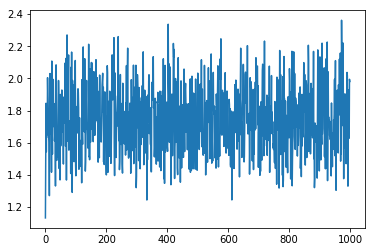

In [20]:
from matplotlib import pyplot as plt
plt.plot(confusion_matrix_text[0,:])

In [24]:
np.argmin(confusion_matrix_text[2,:])

1.2133508

In [10]:
    help(th.sum)


Help on built-in function sum:

sum(...)
    .. function:: sum(input, dtype=None) -> Tensor
    
    Returns the sum of all elements in the :attr:`input` tensor.
    
    Args:
        input (Tensor): the input tensor
        dtype (:class:`torch.dtype`, optional): the desired data type of returned tensor.
            If specified, the input tensor is casted to :attr:`dtype` before the operation
            is performed. This is useful for preventing data type overflows. Default: None.
    
    Example::
    
        >>> a = torch.randn(1, 3)
        >>> a
        tensor([[ 0.1133, -0.9567,  0.2958]])
        >>> torch.sum(a)
        tensor(-0.5475)
    
    .. function:: sum(input, dim, keepdim=False, dtype=None) -> Tensor
    
    Returns the sum of each row of the :attr:`input` tensor in the given
    dimension :attr:`dim`. If :attr::`dim` is a list of dimensions,
    reduce over all of them.
    
    If :attr:`keepdim` is ``True``, the output tensor is of the same size
    as :attr

In [ ]:
aa=confusion_matrix

In [ ]:
sx = np.sort(aa, axis=1)

In [ ]:
d = np.diag(aa) #(1000)
d = d[:,np.newaxis] #(1000,1)

In [ ]:
ind = sx - d

In [ ]:
ind_pos = np.where(ind == 0)

In [ ]:
ind_pos[1][:10]

In [ ]:
def compute_metric_yang(x):
    sx = np.sort(x, axis=1)
    d = np.diag(x) #(1000)
    d = d[:,np.newaxis] #(1000,1)
    ind = sx - d
    ind = np.where(ind == 0)
    ind = ind[1]

    metrics = {}
    metrics['R1'] = float(np.sum(ind == 0))/len(ind)
    metrics['R5'] = float(np.sum(ind < 5))/len(ind)
    metrics['R10'] = float(np.sum(ind < 10))/len(ind)
    metrics['MR'] = np.median(ind) + 1

    return metrics




In [ ]:
 metrics_yang = compute_metric_distance(confusion_matrix)

In [1]:
%run train.py

Namespace(GPU=True, MSRVTT=False, batch_size=128, coco=False, coco_sampling_rate=1.0, epochs=50, eval_qcm=False, lr=0.0001, lr_decay=0.95, margin=0.2, model_name='test', momentum=0.9, n_cpu=4, n_display=100, optimizer='adam', seed=1, text_cluster_size=32)
Pre-loading features ... This may takes several minutes ...
Done.
Reading test data ...
Done.
Starting training loop ...
epoch: 0


/scratch/shared/nfs1/yangl/code/VideoText/VideoRetrival/train.py:275: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  running_loss += loss.data[0]


Epoch 1, Epoch status: 0.13, Training loss: 0.0950
Epoch 1, Epoch status: 0.25, Training loss: 0.0624
Epoch 1, Epoch status: 0.38, Training loss: 0.0544
Epoch 1, Epoch status: 0.51, Training loss: 0.0516
Epoch 1, Epoch status: 0.63, Training loss: 0.0484
Epoch 1, Epoch status: 0.76, Training loss: 0.0474
Epoch 1, Epoch status: 0.89, Training loss: 0.0458
evaluating epoch 1 ...
MPII - epoch: 1, epoch status: 1.00, r@1: 0.079, r@5: 0.196, r@10: 0.276, mr: 37
epoch: 1


/scratch/shared/nfs1/yangl/code/VideoText/VideoRetrival/train.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  video = Variable(vid_retrieval_val.cuda(), volatile=True)
/scratch/shared/nfs1/yangl/code/VideoText/VideoRetrival/train.py:309: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  captions = Variable(text_retrieval_val.cuda(), volatile=True)
/scratch/shared/nfs1/yangl/code/VideoText/VideoRetrival/train.py:310: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  audio = Variable(audio_retrieval_val.cuda(), volatile=True)
/scratch/shared/nfs1/yangl/code/VideoText/VideoRetrival/train.py:311: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  flow = Variable(flow_retrieval_val.cuda(), volatile=True)
/scratch/shared/nfs1/yangl/code/VideoText/VideoRetrival/train.py:312: UserWarning: volatile was re

Epoch 2, Epoch status: 0.13, Training loss: 0.0391
Epoch 2, Epoch status: 0.25, Training loss: 0.0389
Epoch 2, Epoch status: 0.38, Training loss: 0.0383
Epoch 2, Epoch status: 0.51, Training loss: 0.0383
Epoch 2, Epoch status: 0.63, Training loss: 0.0371
Epoch 2, Epoch status: 0.76, Training loss: 0.0382
Epoch 2, Epoch status: 0.89, Training loss: 0.0386
evaluating epoch 2 ...
MPII - epoch: 2, epoch status: 1.00, r@1: 0.092, r@5: 0.236, r@10: 0.323, mr: 32
epoch: 2
Epoch 3, Epoch status: 0.13, Training loss: 0.0326
Epoch 3, Epoch status: 0.25, Training loss: 0.0328
Epoch 3, Epoch status: 0.38, Training loss: 0.0327
Epoch 3, Epoch status: 0.51, Training loss: 0.0328
Epoch 3, Epoch status: 0.63, Training loss: 0.0324
Epoch 3, Epoch status: 0.76, Training loss: 0.0325
Epoch 3, Epoch status: 0.89, Training loss: 0.0326
evaluating epoch 3 ...
MPII - epoch: 3, epoch status: 1.00, r@1: 0.095, r@5: 0.257, r@10: 0.343, mr: 28
epoch: 3
Epoch 4, Epoch status: 0.13, Training loss: 0.0280
Epoch 4, 

Epoch 19, Epoch status: 0.51, Training loss: 0.0073
Epoch 19, Epoch status: 0.63, Training loss: 0.0075
Epoch 19, Epoch status: 0.76, Training loss: 0.0076
Epoch 19, Epoch status: 0.89, Training loss: 0.0079
evaluating epoch 19 ...
MPII - epoch: 19, epoch status: 1.00, r@1: 0.104, r@5: 0.288, r@10: 0.399, mr: 23
epoch: 19
Epoch 20, Epoch status: 0.13, Training loss: 0.0062
Epoch 20, Epoch status: 0.25, Training loss: 0.0065
Epoch 20, Epoch status: 0.38, Training loss: 0.0067
Epoch 20, Epoch status: 0.51, Training loss: 0.0068
Epoch 20, Epoch status: 0.63, Training loss: 0.0069
Epoch 20, Epoch status: 0.76, Training loss: 0.0072
Epoch 20, Epoch status: 0.89, Training loss: 0.0073
evaluating epoch 20 ...
MPII - epoch: 20, epoch status: 1.00, r@1: 0.104, r@5: 0.284, r@10: 0.384, mr: 22
epoch: 20
Epoch 21, Epoch status: 0.13, Training loss: 0.0059
Epoch 21, Epoch status: 0.25, Training loss: 0.0061
Epoch 21, Epoch status: 0.38, Training loss: 0.0062
Epoch 21, Epoch status: 0.51, Training l

Epoch 36, Epoch status: 0.63, Training loss: 0.0032
Epoch 36, Epoch status: 0.76, Training loss: 0.0033
Epoch 36, Epoch status: 0.89, Training loss: 0.0034
evaluating epoch 36 ...
MPII - epoch: 36, epoch status: 1.00, r@1: 0.101, r@5: 0.270, r@10: 0.369, mr: 25
epoch: 36
Epoch 37, Epoch status: 0.13, Training loss: 0.0030
Epoch 37, Epoch status: 0.25, Training loss: 0.0030
Epoch 37, Epoch status: 0.38, Training loss: 0.0031
Epoch 37, Epoch status: 0.51, Training loss: 0.0031
Epoch 37, Epoch status: 0.63, Training loss: 0.0032
Epoch 37, Epoch status: 0.76, Training loss: 0.0032
Epoch 37, Epoch status: 0.89, Training loss: 0.0033
evaluating epoch 37 ...
MPII - epoch: 37, epoch status: 1.00, r@1: 0.096, r@5: 0.266, r@10: 0.364, mr: 25
epoch: 37
Epoch 38, Epoch status: 0.13, Training loss: 0.0029
Epoch 38, Epoch status: 0.25, Training loss: 0.0030
Epoch 38, Epoch status: 0.38, Training loss: 0.0030
Epoch 38, Epoch status: 0.51, Training loss: 0.0030
Epoch 38, Epoch status: 0.63, Training l

In [1]:
import numpy as np

In [5]:
import torch as th

cuda:0


In [11]:
moe_weights=np.zeros((128,4))+0.25
moe_weights = th.from_numpy(aa).float().to(device)

In [12]:
img.shape

torch.Size([128, 4])